<a href="https://colab.research.google.com/github/kooose38/pystan_practice/blob/main/%E9%9A%8E%E5%B1%A4%E3%83%99%E3%82%A4%E3%82%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 階層ベイズモデル
共通部分のパラメータと個人差のパラメータを独立的に調整する。

In [1]:
!unzip data.zip 

Archive:  data.zip
  inflating: data/data.xlsx          
  inflating: data/dose_response.xlsx  
  inflating: data/MAP_sample.xlsx    
  inflating: data/multilevel_modeling.xlsx  
  inflating: data/real_estate1.xlsx  
  inflating: data/real_estate2.xlsx  
  inflating: data/temperature_series.xlsx  
  inflating: data/~$wattage.xlsx     


In [2]:
!pip install -q pystan 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pystan 
from scipy.stats import mstats 

In [5]:
plt.style.use("ggplot")

In [6]:
filename = "data/multilevel_modeling.xlsx"
df = pd.read_excel(filename)
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


* `id`は出席番号で個人ごとに身長の伸びは異なる
 

In [8]:
ids = df["id"].unique().tolist()
ids

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Text(0, 0.5, 'height')

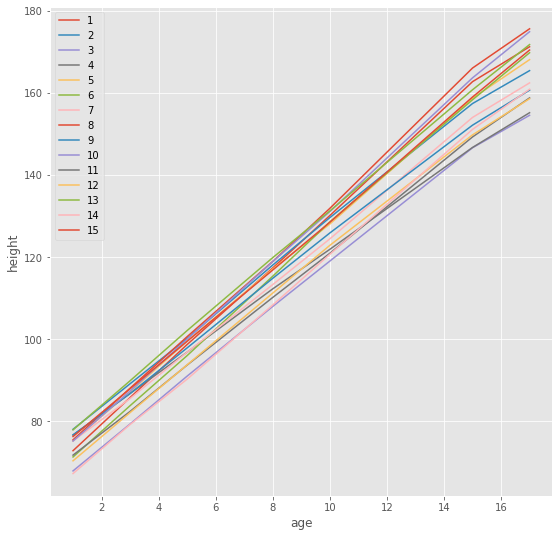

In [10]:
plt.figure(figsize=(9, 9))
for id in ids:
    x = df[df["id"] == id]
    plt.plot(x["age"], x["height"], label=id)
    plt.legend()
plt.xlabel("age")
plt.ylabel("height")

## モデリングの設計
* `a0`, `b0`は共通項
* `a_id`, `b_id`は個体差で*N(0, sigma)*の正規分布に従う
* `a`, `b`は共通項 + 個体差から生成される
* 予測値は*N(aX+b, sigma)*の正規分布に従う

In [14]:
stan_model = """
data {
    int N;
    int N_id;
    real X[N];
    real Y[N];
    int<lower=0, upper=N_id> s_id[N];
}

parameters {
    real a0;
    real b0;
    real a_id[N_id];
    real b_id[N_id];
    real<lower=0> s_a;
    real<lower=0> s_b;
    real<lower=0> s_Y;
}

transformed parameters {
    real a[N_id];
    real b[N_id];
    for (n in 1:N_id) {
        a[n] = a0 + a_id[n];
        b[n] = b0 + b_id[n];
    }
}

model {
    for (id in 1:N_id) {
        a_id[id] ~ normal(0, s_a);
        b_id[id] ~ normal(0, s_b);
    }

    for (n in 1:N) {
        Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
    }
}
"""

In [15]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c17ffcf83eed7cefe10b68ba5afe9f15 NOW.


In [16]:
stan_data = {"N": df.shape[0], "N_id": df["id"].nunique(), "X": df["age"], "Y": df["height"], "s_id": df["id"]}

In [17]:
fit = sm.sampling(data=stan_data, chains=3, iter=3000, warmup=500, seed=123)

In [18]:
fit

Inference for Stan model: anon_model_c17ffcf83eed7cefe10b68ba5afe9f15.
3 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=7500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  4.0e-3   0.11   5.55    5.7   5.77   5.84    6.0    816    1.0
b0         68.2    0.03   0.94  66.36  67.61   68.2  68.82  70.06    989   1.01
a_id[1]    0.46  4.1e-3   0.13    0.2   0.38   0.46   0.54   0.71    987    1.0
a_id[2]   -0.19  4.0e-3   0.13  -0.45  -0.28  -0.19  -0.11   0.06   1009    1.0
a_id[3]    -0.3  3.9e-3   0.13  -0.55  -0.38  -0.29  -0.21  -0.04   1047    1.0
a_id[4]    -0.8  4.0e-3   0.13  -1.05  -0.88   -0.8  -0.72  -0.55   1019    1.0
a_id[5]    0.08  3.9e-3   0.13  -0.16 1.4e-3   0.08   0.16   0.33   1037    1.0
a_id[6]     0.4  4.0e-3   0.13   0.15   0.32    0.4   0.48   0.65   1006    1.0
a_id[7]   -0.21  4.0e-3   0.13  -0.47  -0.29  -0.21  -0.13   0.04   1003    1.0
a_id[8]    0

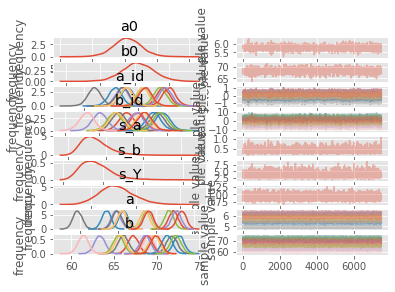

In [19]:
fig = fit.plot()

In [20]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]
ms_a.shape

(7500, 15)

## 1人分のパラメータから信頼区間推定


In [34]:
age = np.arange(15)
df_b = pd.DataFrame([])
for i in range(age.shape[0]):
    df_b[i] = ms_a[:, i] * age[i] + ms_b[:, i]

In [35]:
df_b.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,67.460765,78.504745,74.227188,86.936911,93.427982,96.113878,102.084568,113.666913,114.421811,124.747821,120.885175,127.279159,142.925953,138.864633,152.254881
1,65.208897,78.950741,73.755727,87.023940,92.767136,96.656675,102.393743,112.944779,113.773317,125.089573,121.208619,126.342581,143.152049,138.203792,151.620570
2,67.033850,79.000412,75.748511,86.866583,93.010432,96.228997,101.886728,113.318012,114.188113,124.823742,120.712121,127.249151,143.240844,137.546848,152.051449
3,66.983480,78.239994,74.388917,87.195686,92.257138,95.978274,101.513148,113.264215,113.986593,125.449596,121.111558,125.826484,142.694596,137.044153,152.704908
4,66.886394,78.631979,73.181331,86.897169,93.182402,96.632252,101.832927,113.042885,113.777747,124.455391,121.016881,127.410077,142.550344,137.770057,152.573125


In [36]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [40]:
df_0 = df.loc[df["id"] == 1, ["age", "height"]]
df_0

,age,height
0,1,72.737927
1,3,85.694575
2,5,98.635829
3,8,117.302636
4,10,130.076144
5,15,162.717327
6,17,171.236888


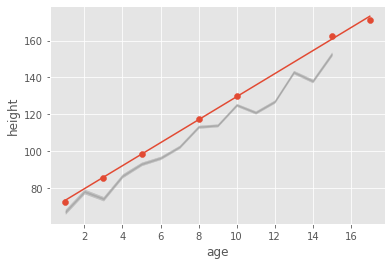

In [50]:
a, b = 6.23, 67.25 
y = a * df_0["age"] + b 
plt.scatter(df_0["age"], df_0["height"])
plt.plot(df_0.age, y)
plt.fill_between(age + 1, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(age + 1, low_y95, high_y95, alpha=0.3, color="gray")
plt.xlabel("age")
plt.ylabel("height")
plt.show()

共通項のサンプリングのため、誤差が検知された。